In [7]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
sys.path.append('../../common/src')
import os
import copy
import numpy as np

from validation.data import load_from_jsonl

from validation.analysis import generate_name_from_config, find_optimal_bounds_parallel, evaluate_bound, classify_data
from validation.analysis import analyze, process_data, plot_classification_results, plot_length_vs_distance_comparison
from validation.analysis import plot_violin_comparison

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model_name = 'qwen30B'
honest_data_paths = [
    '../data/inference_results/Qwen3-30B-A3B-Instruct-2507-FP8-fp8-1xH100___Qwen3-30B-A3B-Instruct-2507-FP8-fp8-1xH100.jsonl',
    '../data/inference_results/Qwen3-30B-A3B-Instruct-2507-FP8-fp8-2x3090___Qwen3-30B-A3B-Instruct-2507-FP8-fp8-1xH100.jsonl',
    '../data/inference_results/Qwen3-30B-A3B-Instruct-2507-FP8-fp8-2x3090___Qwen3-30B-A3B-Instruct-2507-FP8-fp8-2x3090.jsonl'
]
fraud_data_paths = [
    '../data/inference_results/Qwen3-30B-A3B-Instruct-2507-AWQ-4bit-int4-1xH100___Qwen3-30B-A3B-Instruct-2507-FP8-fp8-1xH100.jsonl',
    '../data/inference_results/Qwen3-30B-A3B-Instruct-2507-AWQ-4bit-int4-2x3090___Qwen3-30B-A3B-Instruct-2507-FP8-fp8-1xH100.jsonl',
]
DATA_PATH = {generate_name_from_config(dp, model_name): dp for dp in honest_data_paths + fraud_data_paths}

In [3]:
honest_items_dict, honest_distances_dict = {}, {}
fraud_items_dict, fraud_distances_dict = {}, {}
honest_distances, fraud_distances = [], []

for name, path in DATA_PATH.items():
    items, distances, topk = process_data(load_from_jsonl(path, n=1000))
    if 'honest' in name:
        honest_items_dict[name] = items
        honest_distances_dict[name] = distances
        honest_distances.extend(distances)
    if 'fraud' in name:
        fraud_items_dict[name] = items
        fraud_distances_dict[name] = distances
        fraud_distances.extend(distances)

Dropped 0 / 1000 items
Dropped 0 / 200 items
Dropped 0 / 200 items
Dropped 0 / 200 items
Dropped 0 / 200 items


In [4]:
optimal_lower, optimal_upper = find_optimal_bounds_parallel(honest_distances, fraud_distances, n_jobs=64, step=0.001)

Searching optimal bounds: 100%|████████████████| 87/87 [00:00<00:00, 167.33it/s]


Optimal Lower Bound: 0.026176
Optimal Upper Bound: 0.027176
Best F1-Score: 0.7261


Thresholds: 0.0262, 0.0272


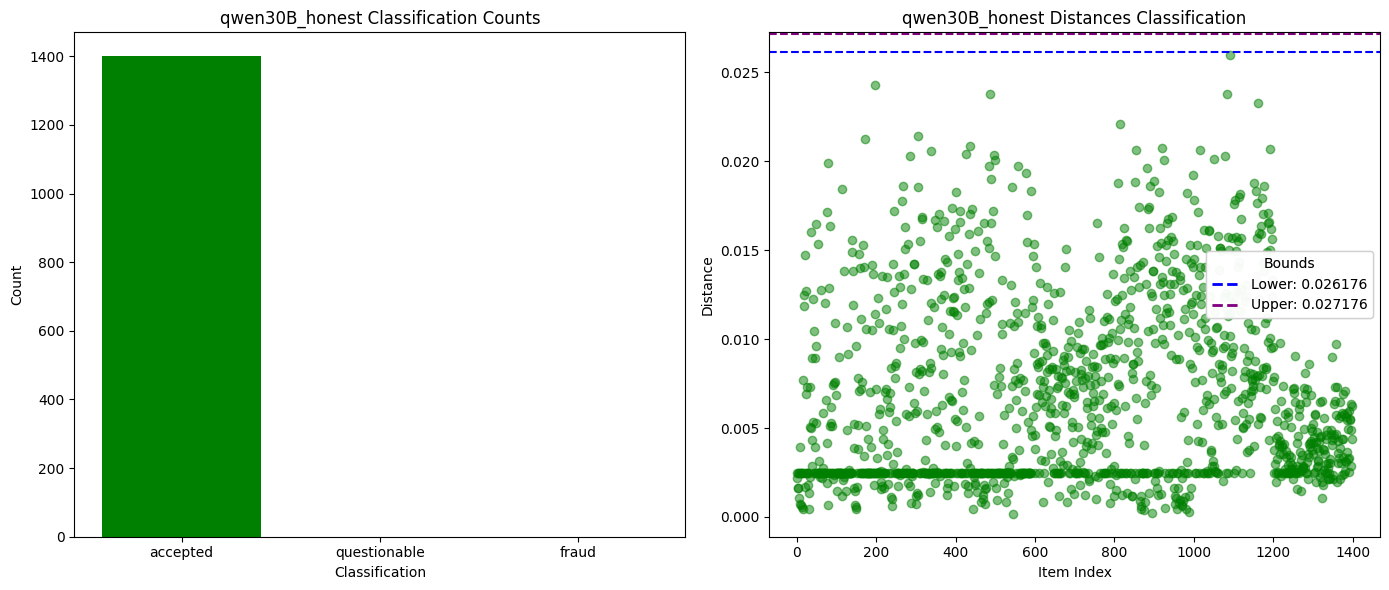

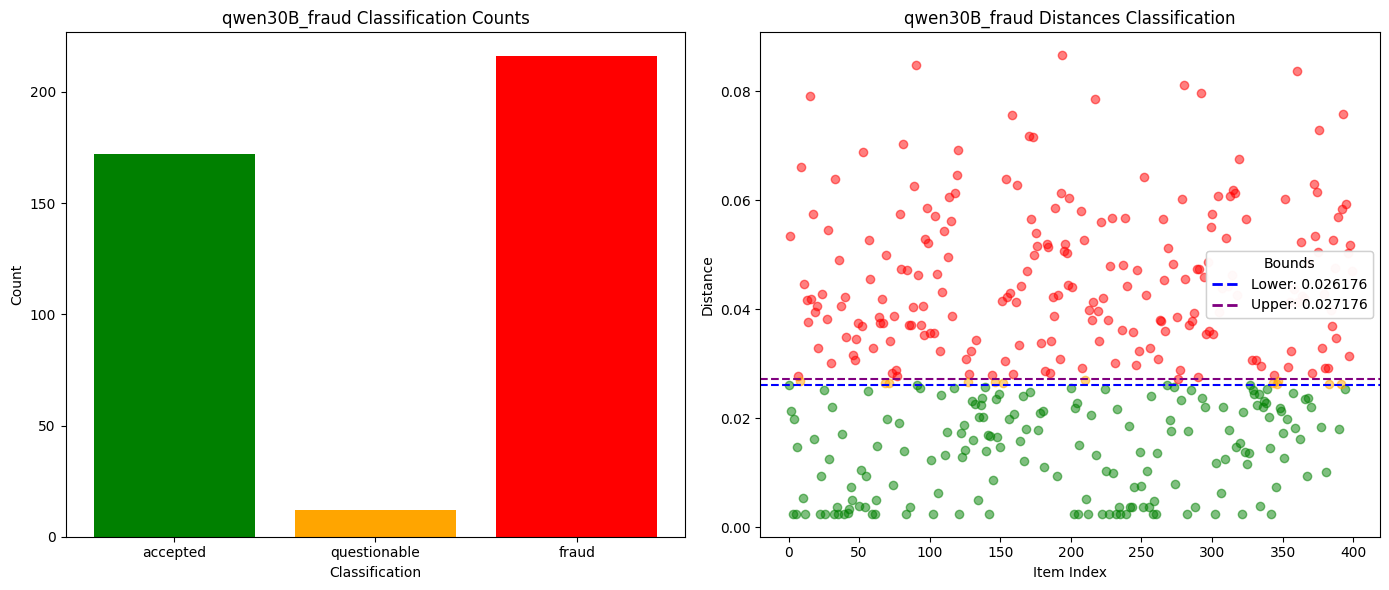

Share of fraud found = 0.54


/root/gonka/mlnode/packages/benchmarks/notebooks/../src/validation/analysis.py:424: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


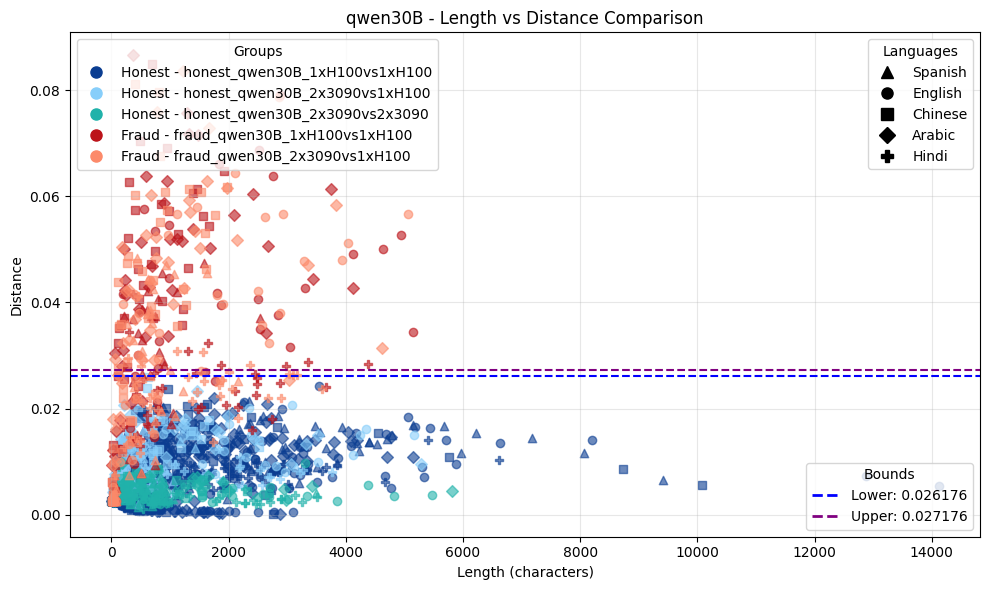

In [5]:
print(f"Thresholds: {optimal_lower:.4f}, {optimal_upper:.4f}")

classifications_honest = classify_data(honest_distances, optimal_lower, optimal_upper)
classifications_fraud = classify_data(fraud_distances, optimal_lower, optimal_upper)

plot_classification_results(
    honest_distances,
    classifications_honest,
    optimal_lower, optimal_upper,
    title_prefix=f"{model_name}_honest",
    # save_to='../data/graphs'
)
plot_classification_results(
    fraud_distances,
    classifications_fraud,
    optimal_lower,
    optimal_upper,
    title_prefix=f"{model_name}_fraud",
    # save_to='../data/graphs'
)
print('Share of fraud found =', sum(np.array(classifications_fraud) == 'fraud')/len(classifications_fraud))
plot_length_vs_distance_comparison(
    model_name,
    honest_items_dict,
    honest_distances_dict,
    fraud_items_dict,
    fraud_distances_dict,
    bounds = (optimal_lower, optimal_upper),
    # save_to='../data/graphs'
)


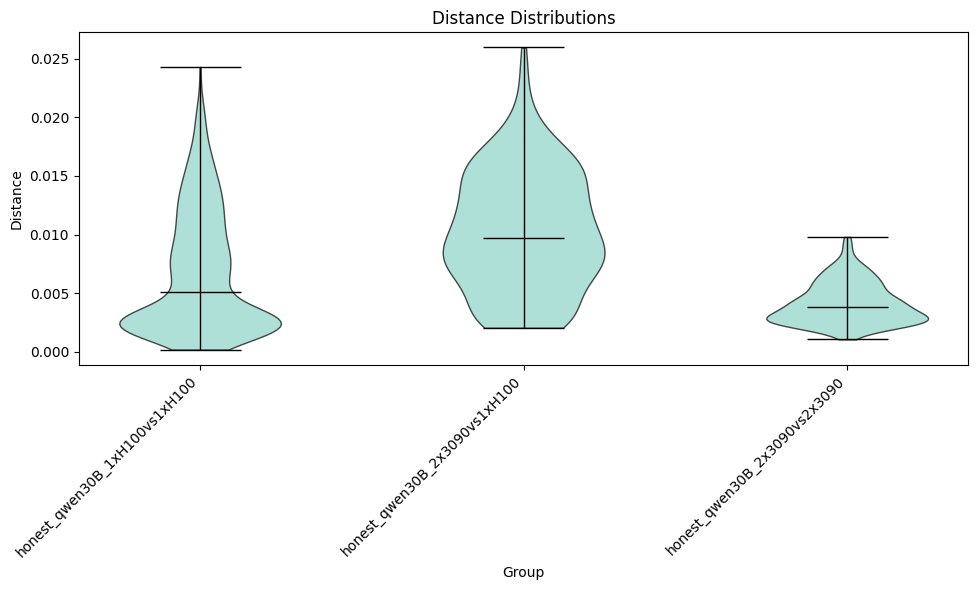

Mean and std per group:
  honest_qwen30B_2x3090vs2x3090: n=200, mean=0.004161, std=0.001773
  honest_qwen30B_1xH100vs1xH100: n=1000, mean=0.006755, std=0.005227
  honest_qwen30B_2x3090vs1xH100: n=200, mean=0.010275, std=0.005120
Delta mean: 0.006113 (honest_qwen30B_2x3090vs2x3090 -> honest_qwen30B_2x3090vs1xH100)
Std range: 0.001773 (honest_qwen30B_2x3090vs2x3090) .. 0.005227 (honest_qwen30B_1xH100vs1xH100)


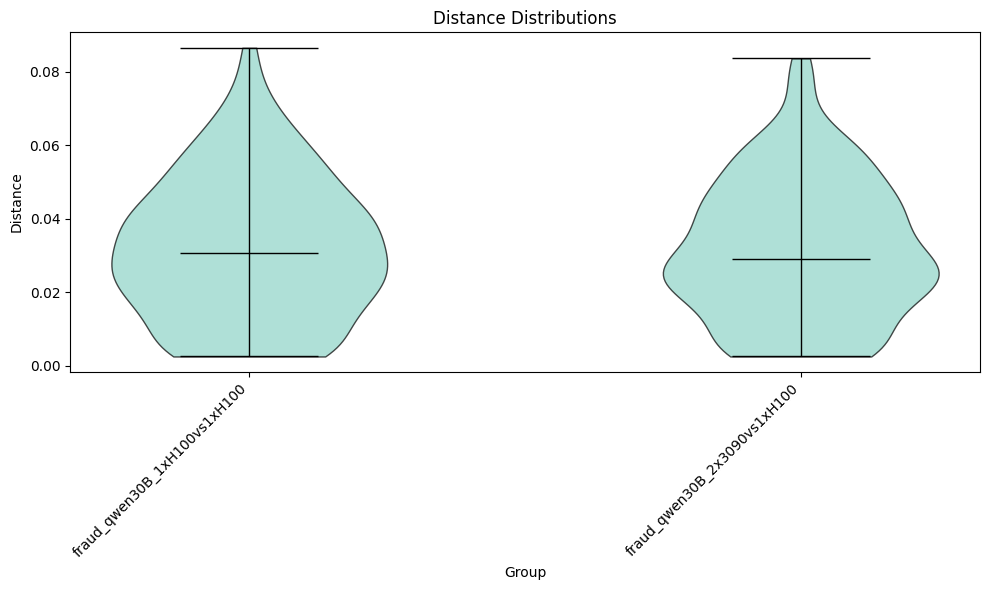

Mean and std per group:
  fraud_qwen30B_2x3090vs1xH100: n=200, mean=0.031390, std=0.019054
  fraud_qwen30B_1xH100vs1xH100: n=200, mean=0.032029, std=0.019507
Delta mean: 0.000639 (fraud_qwen30B_2x3090vs1xH100 -> fraud_qwen30B_1xH100vs1xH100)
Std range: 0.019054 (fraud_qwen30B_2x3090vs1xH100) .. 0.019507 (fraud_qwen30B_1xH100vs1xH100)


In [8]:
plot_violin_comparison(honest_distances_dict)
plot_violin_comparison(fraud_distances_dict)